In [31]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import joblib

In [46]:
import joblib
import os

# Load the previously saved SHAP-selected features
feature_path = "../models/lgbm_model_SHAP_selected_features.pkl"
shap_selected_features = joblib.load(feature_path)

# Define non-feature columns to exclude
non_feature_columns = {"time_id", "weight", "date_id", "symbol_id"}

# Remove non-features and feature_60_transformed
final_selected_features = set(shap_selected_features) - non_feature_columns - {"feature_60_transformed"}

# Ensure transformed features are included (without duplicates)
final_selected_features.update(["feature_45_log", "feature_23_squared"])

# Convert back to a sorted list for consistency
final_selected_features = sorted(final_selected_features)

# Define the save path for the updated features
feature_save_path = "../models/lgbm_model_SHAP_selected_features_updated.pkl"

# Save the updated list of features
joblib.dump(final_selected_features, feature_save_path)

print(f"Updated selected features saved at: {feature_save_path}")
print(f"Final feature list ({len(final_selected_features)} features): {final_selected_features}")

Updated selected features saved at: ../models/lgbm_model_SHAP_selected_features_updated.pkl
Final feature list (52 features): ['feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_16', 'feature_18', 'feature_19', 'feature_20', 'feature_22', 'feature_23_squared', 'feature_25', 'feature_28', 'feature_30', 'feature_32', 'feature_33', 'feature_35', 'feature_36', 'feature_38', 'feature_39', 'feature_42', 'feature_44', 'feature_45_log', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_65', 'feature_66', 'feature_68', 'feature_69', 'feature_70', 'feature_71', 'feature_72', 'feature_76', 'feature_78']


In [48]:
# Re-run the model with transformed features

import joblib
import lightgbm as lgb
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the updated feature selection
feature_path = "../models/lgbm_model_SHAP_selected_features_updated.pkl"
selected_features = joblib.load(feature_path)

print(f"Loaded {len(selected_features)} selected features.")

# Load the cleaned dataset
data_path = "../data/processed/day0_data_cleaned_finalcode.parquet"
day0_data_cleaned = pd.read_parquet(data_path)

# Ensure transformed features are present in the dataset

# Feature 45 - Log Transformation
if "feature_45" in day0_data_cleaned.columns and "feature_45_log" not in day0_data_cleaned.columns:
    day0_data_cleaned["feature_45_log"] = np.where(day0_data_cleaned["feature_45"] > 0, 
                                                   np.log1p(day0_data_cleaned["feature_45"]), 
                                                   day0_data_cleaned["feature_45"])
    print("Applied log transformation to Feature 45.")

# Feature 23 - Squared Transformation
if "feature_23" in day0_data_cleaned.columns and "feature_23_squared" not in day0_data_cleaned.columns:
    day0_data_cleaned["feature_23_squared"] = day0_data_cleaned["feature_23"] ** 2
    print("Applied squared transformation to Feature 23.")

# Drop the original columns after transformation (optional)
day0_data_cleaned = day0_data_cleaned.drop(columns=["feature_45", "feature_23"], errors="ignore")

# Define features (X) and target (y)
X = day0_data_cleaned[selected_features]  # Use only selected features
y = day0_data_cleaned["responder_6"]  # Target variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

# Initialize and train the LightGBM model
lgb_model_updated = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

print("Training LightGBM on updated feature selection...")
lgb_model_updated.fit(X_train, y_train)
print("Model training complete!")

# Make predictions
y_pred_updated = lgb_model_updated.predict(X_test)

# Compute evaluation metrics
mse_updated = mean_squared_error(y_test, y_pred_updated)
rmse_updated = np.sqrt(mse_updated)
mae_updated = mean_absolute_error(y_test, y_pred_updated)
r2_updated = r2_score(y_test, y_pred_updated)

# Print results
print("\nModel Evaluation on Updated Features:")
print(f"Test MSE: {mse_updated}")
print(f"Test RMSE: {rmse_updated}")
print(f"Test MAE: {mae_updated}")
print(f"Test R²: {r2_updated}")

# Save the retrained model
model_save_path = "../models/lgbm_model_top30_SHAP_updated.pkl"
joblib.dump(lgb_model_updated, model_save_path)

print(f"Updated model saved at: {model_save_path}")

Loaded 52 selected features.


/Users/caroline/Documents/TUM/Python/Marketforecasting_Python/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applied log transformation to Feature 45.
Applied squared transformation to Feature 23.
Training Features Shape: (1555368, 52)
Testing Features Shape: (388842, 52)
Training LightGBM on updated feature selection...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 52
[LightGBM] [Info] Start training from score 0.001706
Model training complete!

Model Evaluation on Updated Features:
Test MSE: 0.4286393191179276
Test RMSE: 0.654705520916028
Test MAE: 0.45513229494838053
Test R²: 0.43557656606259143
Updated model saved at: ../models/lgbm_model_top30_SHAP_updated.pkl


In [53]:
# Apply Bayesian Optimization

from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import numpy as np
from tqdm import tqdm

# Define the function to optimize
def lgbm_evaluate(num_leaves, max_depth, learning_rate, min_child_samples, subsample, colsample_bytree):
    """Objective function for Bayesian Optimization"""
    
    # Convert float inputs to integers where necessary
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    min_child_samples = int(min_child_samples)

    # Initialize LightGBM model
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_estimators=1000,
        random_state=42,
        n_jobs=-1
    )
    
    # Perform cross-validation (Faster scoring)
    score = cross_val_score(model, X_train, y_train, cv=2, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    
    return score  # Return the mean RMSE (negative for maximization)

# Define the parameter search space (Reduced for speed)
param_bounds = {
    "num_leaves": (20, 150),  
    "max_depth": (3, 12),  
    "learning_rate": (0.02, 0.2),  
    "min_child_samples": (10, 40),  
    "subsample": (0.6, 1.0),  
    "colsample_bytree": (0.6, 1.0)  
}

# Initialize Bayesian Optimization
lgb_bo = BayesianOptimization(
    f=lgbm_evaluate,         
    pbounds=param_bounds,    
    random_state=42,         
    verbose=2                
)

# Set the number of initial random trials and iterations
init_points = 3  # Fewer random trials
n_iter = 15      # Reduced iterations for speed

# Progress tracking
pbar = tqdm(total=init_points + n_iter, desc="Bayesian Optimization Progress", unit="iteration")

# Run Bayesian Optimization with progress tracking
for i in range(init_points + n_iter):
    lgb_bo.maximize(init_points=0 if i >= init_points else 1, n_iter=1)
    pbar.update(1)

pbar.close()

# Get best parameters
best_params = lgb_bo.max["params"]

# Convert float values to integer where needed
best_params["num_leaves"] = int(best_params["num_leaves"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_samples"] = int(best_params["min_child_samples"])

print("\nOptimized Hyperparameters:")
print(best_params)

Bayesian Optimization Progress:  11%|█▏        | 4/35 [13:32<1:44:53, 203.02s/iteration]

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
| 1         | -0.7451   | 0.7498    | 0.1911    | 9.588     | 27.96     | 40.28     | 0.6624    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

Bayesian Optimization Progress:   6%|▌         | 1/18 [01:37<27:37, 97.52s/iteration]

| 2         | -0.714    | 0.9014    | 0.1744    | 8.311     | 20.99     | 77.33     | 0.9145    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
| 3         | -0.7

Bayesian Optimization Progress:  11%|█         | 2/18 [03:02<24:03, 90.20s/iteration]

| 4         | -0.7951   | 0.6374    | 0.03778   | 8.981     | 19.89     | 76.87     | 0.98      |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightG

Bayesian Optimization Progress:  17%|█▋        | 3/18 [04:17<20:45, 83.02s/iteration]

| 6         | -0.8016   | 0.6841    | 0.1986    | 4.925     | 31.03     | 84.43     | 0.7151    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311


Bayesian Optimization Progress:  22%|██▏       | 4/18 [05:10<16:36, 71.16s/iteration]

| 7         | -0.7336   | 0.9158    | 0.1164    | 11.05     | 23.72     | 74.92     | 0.8615    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features:

Bayesian Optimization Progress:  28%|██▊       | 5/18 [05:45<12:38, 58.36s/iteration]

| 8         | -0.8359   | 0.7751    | 0.04906   | 4.262     | 10.05     | 149.7     | 0.8131    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102


Bayesian Optimization Progress:  33%|███▎      | 6/18 [06:27<10:32, 52.73s/iteration]

| 9         | -0.7928   | 0.8913    | 0.09861   | 6.796     | 10.91     | 29.83     | 0.8665    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311


Bayesian Optimization Progress:  39%|███▉      | 7/18 [07:04<08:43, 47.64s/iteration]

| 10        | -0.7726   | 0.7675    | 0.1506    | 7.69      | 32.25     | 30.17     | 0.6131    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightG

Bayesian Optimization Progress:  44%|████▍     | 8/18 [08:09<08:52, 53.26s/iteration]

| 11        | -0.7067   | 0.895     | 0.1625    | 8.188     | 21.71     | 94.4      | 0.6298    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107524 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightG

Bayesian Optimization Progress:  50%|█████     | 9/18 [09:30<09:17, 61.90s/iteration]

| 12        | -0.7952   | 0.8888    | 0.02516   | 9.963     | 30.0      | 109.7     | 0.8145    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightG

Bayesian Optimization Progress:  56%|█████▌    | 10/18 [10:31<08:12, 61.58s/iteration]

| 13        | -0.7784   | 0.9502    | 0.08022   | 6.024     | 38.22     | 91.19     | 0.6897    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Warnin

Bayesian Optimization Progress:  61%|██████    | 11/18 [11:20<06:44, 57.76s/iteration]

| 14        | -0.7694   | 0.7754    | 0.1966    | 5.383     | 25.75     | 56.65     | 0.8285    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Info] Start training from score 0.002311


Bayesian Optimization Progress:  67%|██████▋   | 12/18 [12:19<05:49, 58.17s/iteration]

| 15        | -0.746    | 0.6475    | 0.08332   | 9.707     | 30.44     | 93.36     | 0.7429    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086491 seconds.
You can set `force_col_wise=true` to remove the overhead.[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087656 seconds.
You can set `force_col_wise=true` to remove the overhead.

[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Start training from score 0.001102


Bayesian Optimization Progress:  72%|███████▏  | 13/18 [12:52<04:12, 50.48s/iteration]

| 16        | -0.7896   | 0.7389    | 0.142     | 7.385     | 12.75     | 21.98     | 0.6883    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Warnin

Bayesian Optimization Progress:  78%|███████▊  | 14/18 [14:36<04:26, 66.58s/iteration]

| 17        | -0.6832   | 0.8599    | 0.1766    | 8.033     | 19.92     | 143.6     | 0.8229    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12443[LightGBM] [Info] Total Bins 12443

[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightG

Bayesian Optimization Progress:  83%|████████▎ | 15/18 [15:24<03:02, 60.92s/iteration]

| 18        | -0.8142   | 0.8095    | 0.04514   | 7.294     | 26.0      | 34.43     | 0.7192    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

Bayesian Optimization Progress:  89%|████████▉ | 16/18 [16:00<01:46, 53.39s/iteration]

| 19        | -0.8409   | 0.6903    | 0.039     | 4.421     | 26.07     | 123.0     | 0.9011    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Warnin

Bayesian Optimization Progress:  94%|█████████▍| 17/18 [17:19<01:01, 61.24s/iteration]

| 20        | -0.705    | 0.6888    | 0.1326    | 8.325     | 10.38     | 127.3     | 0.7079    |
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.001102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 777684, number of used features: 52
[LightGBM] [Info] Start training from score 0.002311


Bayesian Optimization Progress: 100%|██████████| 18/18 [18:00<00:00, 60.05s/iteration]

| 21        | -0.7546   | 0.6418    | 0.1536    | 8.251     | 37.7      | 44.52     | 0.6793    |

Optimized Hyperparameters:
{'colsample_bytree': np.float64(0.8598518222709595), 'learning_rate': np.float64(0.17662355114631598), 'max_depth': 8, 'min_child_samples': 19, 'num_leaves': 143, 'subsample': np.float64(0.8228520275081437)}


In [54]:
import lightgbm as lgb
import joblib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the best hyperparameters from Bayesian Optimization
best_params = lgb_bo.max["params"]

# Convert float values to integer where needed
best_params["num_leaves"] = int(best_params["num_leaves"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_samples"] = int(best_params["min_child_samples"])

# Train the final model using the best hyperparameters
lgb_model_optimized = lgb.LGBMRegressor(
    num_leaves=best_params["num_leaves"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    min_child_samples=best_params["min_child_samples"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    n_estimators=1000,
    random_state=42,
    n_jobs=-1
)

print("Training the optimized LightGBM model...")

# Train on the same dataset
lgb_model_optimized.fit(X_train, y_train)

print("Optimized model training complete!")

# Save the optimized model
optimized_model_path = "../models/lgbm_model_top30_SHAP_optimized.pkl"
joblib.dump(lgb_model_optimized, optimized_model_path)

print(f"Optimized model saved at: {optimized_model_path}")

Training the optimized LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 52
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [55]:
# Make predictions using the optimized model
y_pred_optimized = lgb_model_optimized.predict(X_test)

# Compute evaluation metrics
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Print results
print("\nOptimized Model Performance:")
print(f"Test MSE: {mse_optimized}")
print(f"Test RMSE: {rmse_optimized}")
print(f"Test MAE: {mae_optimized}")
print(f"Test R²: {r2_optimized}")


Optimized Model Performance:
Test MSE: 0.41699937756223376
Test RMSE: 0.6457548896928569
Test MAE: 0.4463311506519762
Test R²: 0.4509038015509622


In [ ]:
# Slight improvement with the optimization, but no major changes. No trying a more complex version.

Loaded 52 selected features.


Optimization Progress:   0%|          | 0/15 [00:00<?, ?it/s]

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001545
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269912 seconds.
You can set `force_col_wise=true` 

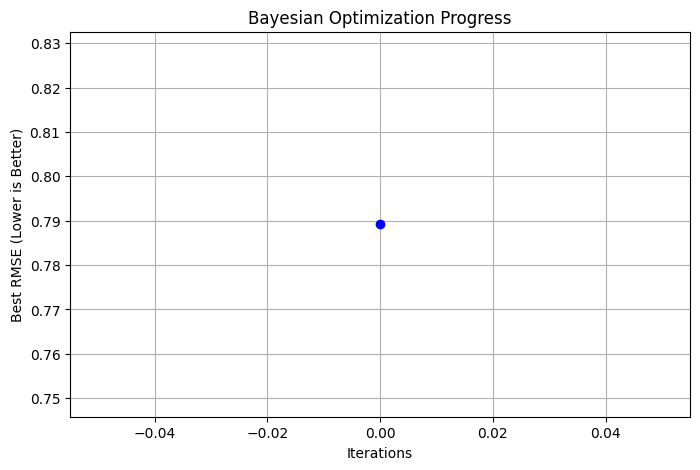

Optimization Progress:   7%|▋         | 1/15 [04:50<1:07:44, 290.36s/it]

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Total Bins 

Optimization Progress:  13%|█▎        | 2/15 [10:18<1:07:45, 312.75s/it]

| 12        | -0.7758   | 0.1094    | 7.968     | 10.53     | 71.71     | 0.8772    |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.002037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

Optimization Progress:  20%|██        | 3/15 [16:10<1:06:04, 330.38s/it]

| 18        | -0.7706   | 0.08748   | 10.93     | 46.18     | 91.7      | 0.914     |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001545
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001537
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Optimization Progress:  27%|██▋       | 4/15 [21:55<1:01:39, 336.30s/it]

| 24        | -0.7898   | 0.05822   | 13.49     | 48.0      | 89.11     | 0.6935    |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.002037
[LightGBM] [Info] Start training from score 0.001537
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Optimization Progress:  33%|███▎      | 5/15 [27:22<55:31, 333.11s/it]  

| 30        | -0.7471   | 0.1337    | 12.63     | 48.27     | 91.95     | 0.7809    |
|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001537
[LightGBM] [Info] Start training from sco

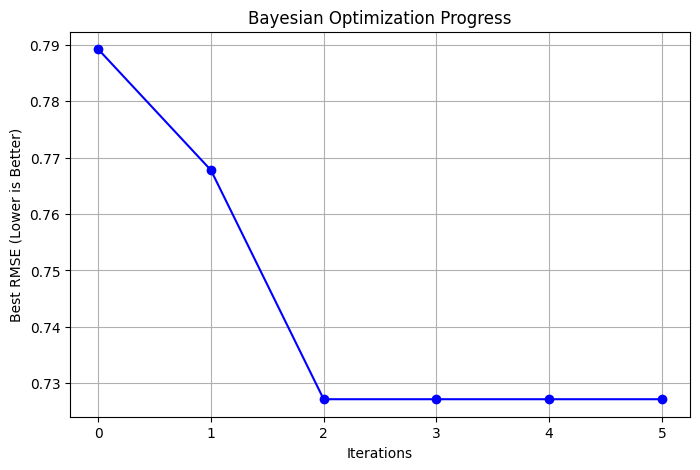

Optimization Progress:  40%|████      | 6/15 [32:35<48:55, 326.17s/it]

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.002037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1036912, number of used features: 52
[LightGBM] [Info] Start training from score 0.001537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

Optimization Progress:  40%|████      | 6/15 [37:27<56:11, 374.58s/it]

| 42        | -0.7296   | 0.1822    | 12.48     | 12.12     | 89.12     | 0.818     |
Early stopping triggered due to minimal improvement.

Best Parameters Found: {'learning_rate': np.float64(0.19422107927526613), 'max_depth': 12, 'min_child_samples': 47, 'num_leaves': 90, 'subsample': np.float64(0.8391599915244341)}
Best parameters saved at: ../models/best_lgbm_hyperparameters.pkl

Total Optimization Time: 37.46 minutes


In [57]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import joblib
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the updated model with SHAP-selected features
model_path = "../models/lgbm_model_top30_SHAP_updated.pkl"
lgb_model_updated = joblib.load(model_path)

# Load the updated feature selection
feature_path = "../models/lgbm_model_SHAP_selected_features_updated.pkl"
selected_features = joblib.load(feature_path)

print(f"Loaded {len(selected_features)} selected features.")

# Define the objective function for Bayesian Optimization
def lgb_evaluate(num_leaves, max_depth, learning_rate, min_child_samples, subsample):
    params = {
        "num_leaves": int(num_leaves),
        "max_depth": int(max_depth),
        "learning_rate": learning_rate,
        "min_child_samples": int(min_child_samples),
        "subsample": subsample,
        "n_estimators": 500,  # Reduced for faster evaluation
        "objective": "regression",
        "metric": "rmse",
        "random_state": 42,
        "n_jobs": -1
    }

    model = lgb.LGBMRegressor(**params)
    
    # Use cross-validation for more robust evaluation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
    
    return np.mean(score)  # Maximizing negative RMSE (minimizing RMSE)

# Define the parameter space with reduced boundaries for efficiency
param_bounds = {
    "num_leaves": (10, 100),
    "max_depth": (3, 15),
    "learning_rate": (0.01, 0.2),
    "min_child_samples": (5, 50),
    "subsample": (0.6, 1.0)
}

# Initialize Bayesian Optimization with smarter exploration
lgb_bo = BayesianOptimization(f=lgb_evaluate, pbounds=param_bounds, random_state=42, verbose=2)

# Define the number of initial random samples and iterations
init_points = 5  # Reduced from previous values
n_iter = 15  # Optimized for speed

# Initialize progress tracking
progress = []
start_time = time.time()

# Run Bayesian Optimization with a real-time progress chart
for i in tqdm(range(n_iter), desc="Optimization Progress"):
    lgb_bo.maximize(init_points=init_points, n_iter=1)
    
    # Track progress
    best_rmse = -lgb_bo.max["target"]
    progress.append(best_rmse)
    
    # Plot progress every 5 iterations
    if i % 5 == 0 or i == n_iter - 1:
        plt.figure(figsize=(8, 5))
        plt.plot(progress, marker="o", linestyle="-", color="blue")
        plt.xlabel("Iterations")
        plt.ylabel("Best RMSE (Lower is Better)")
        plt.title("Bayesian Optimization Progress")
        plt.grid()
        plt.show()
    
    # Stop early if no significant improvement in 5 iterations
    if len(progress) > 5 and abs(progress[-1] - progress[-5]) < 0.0001:
        print("Early stopping triggered due to minimal improvement.")
        break

# Store the best hyperparameters
best_params = lgb_bo.max["params"]
best_params["num_leaves"] = int(best_params["num_leaves"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_samples"] = int(best_params["min_child_samples"])

print(f"\nBest Parameters Found: {best_params}")

# Save the best parameters
param_save_path = "../models/best_lgbm_hyperparameters.pkl"
joblib.dump(best_params, param_save_path)
print(f"Best parameters saved at: {param_save_path}")

# Print total time taken
end_time = time.time()
total_time = (end_time - start_time) / 60
print(f"\nTotal Optimization Time: {total_time:.2f} minutes")

In [58]:
import joblib

# Load the best hyperparameters found during Bayesian Optimization
param_path = "../models/best_lgbm_hyperparameters.pkl"
best_params = joblib.load(param_path)

print("Loaded Best Hyperparameters:", best_params)

Loaded Best Hyperparameters: {'learning_rate': np.float64(0.19422107927526613), 'max_depth': 12, 'min_child_samples': 47, 'num_leaves': 90, 'subsample': np.float64(0.8391599915244341)}


In [59]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
data_path = "../data/processed/day0_data_cleaned_finalcode.parquet"
day0_data_cleaned = pd.read_parquet(data_path)

# Load the selected features
feature_path = "../models/lgbm_model_SHAP_selected_features_updated.pkl"
selected_features = joblib.load(feature_path)

# Ensure transformed features are included
if "feature_45" in day0_data_cleaned.columns and "feature_45_log" not in day0_data_cleaned.columns:
    day0_data_cleaned["feature_45_log"] = np.where(day0_data_cleaned["feature_45"] > 0, 
                                                   np.log1p(day0_data_cleaned["feature_45"]), 
                                                   day0_data_cleaned["feature_45"])
    print("Applied log transformation to Feature 45.")

if "feature_23" in day0_data_cleaned.columns and "feature_23_squared" not in day0_data_cleaned.columns:
    day0_data_cleaned["feature_23_squared"] = day0_data_cleaned["feature_23"] ** 2
    print("Applied squared transformation to Feature 23.")

# Drop the original columns after transformation
day0_data_cleaned = day0_data_cleaned.drop(columns=["feature_45", "feature_23"], errors="ignore")

# Define features (X) and target (y)
X = day0_data_cleaned[selected_features]  
y = day0_data_cleaned["responder_6"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

# Train the optimized LightGBM model
lgb_model_final = lgb.LGBMRegressor(**best_params, n_estimators=1000, random_state=42, n_jobs=-1)

print("Training Final LightGBM Model with Optimized Hyperparameters...")
lgb_model_final.fit(X_train, y_train)
print("Final Model Training Complete!")

/Users/caroline/Documents/TUM/Python/Marketforecasting_Python/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applied log transformation to Feature 45.
Applied squared transformation to Feature 23.
Training Features Shape: (1555368, 52)
Testing Features Shape: (388842, 52)
Training Final LightGBM Model with Optimized Hyperparameters...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12443
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 52
[LightGBM] [Info] Start training from score 0.001706
Final Model Training Complete!


In [60]:
# Make predictions on test set
y_pred_final = lgb_model_final.predict(X_test)

# Compute performance metrics
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

# Print results
print("\nFinal Model Performance:")
print(f"Test MSE: {mse_final}")
print(f"Test RMSE: {rmse_final}")
print(f"Test MAE: {mae_final}")
print(f"Test R²: {r2_final}")


Final Model Performance:
Test MSE: 0.44285050845629553
Test RMSE: 0.6654701409201584
Test MAE: 0.459191935727467
Test R²: 0.4168635644107537
